# Tech Stack Analysis and Trends in Web Development

[GitHub Repo](https://github.com/davidhwilliams/tech-stack-analysis)

### Objective

The primary goal of this project is to explore and uncover relationships between commonly used **frontend** and **backend** technologies in modern web application development. By leveraging unsupervised machine learning techniques, the project aims to identify:

- Common pairings of frontend and backend frameworks (e.g., React with Node.js or Vue with Laravel).
- Unique clusters that represent specific tech stack trends or niche combinations.
- Patterns that differentiate modern tech stacks from legacy or specialized configurations.

### Motivation

Understanding these relationships can provide insights into:

- **Technology trends**: Which combinations are most prevalent in high-performing or scalable projects.
- **Developer ecosystems**: How developers pair technologies across domains and industries.
- **Decision-making**: Informing organizations about common and effective tech stack choices for their projects.

### Methodology Overview

To achieve the objective I will conduct the following steps:

1. **Data Collection**: Tech stack data from sources like GitHub (e.g., `package.json`, `requirements.txt`).
2. **Feature Engineering**: Representation of frontend-backend technologies as vectors.
3. **Clustering and Dimensionality Reduction**: Applying a clustering algorithm like K-Means or DBSCAN to group tech stacks based on similarity.
4. **Visualization and Analysis**: Using charts and plots to illustrate relationships and trends.


# Data Collection

I collected data by interacting with the GitHub API to retrieve repository information and extract dependency files such as `package.json`. This allowed analysis of the technologies and libraries used in various projects.

### Steps

1. **Fetch Repository URLs**:

   - Used the `fetch_repositories` function to query the GitHub API based on a search term (e.g., "web app").
   - Retrieved repository URLs across multiple pages with a specific number of results per page.
   - Saved the results to `repository_urls.csv`.

2. **Fetch Dependency Files**:

   - Used the `fetch_multiple_files` function to retrieve dependency files (e.g., `package.json`, `requirements.txt`) from the repositories.
   - Downloaded file contents via the GitHub API and decoded them for analysis.
   - Aggregated results using the `fetch_dependencies_from_repos_extended` function for multiple repositories.

3. **Save Data**:
   - Saved the dependency data to `dependencies.csv` for future preprocessing and clustering.

### Future Improvements

- Add support for more dependency file types like `pom.xml` (Java) and `Gemfile` (Ruby).
- Implement better handling of API rate limits.
- Use parallel processing to speed up data collection.


In [1]:
import requests
import pandas as pd
import numpy as np
import time
import os
from dotenv import load_dotenv
import json
import base64
import re
import ast


# GitHub API Configuration
# USE A PAT (Personal Access Token) to authenticate to GitHub API. Store this token in a .env file
load_dotenv()
GITHUB_TOKEN = os.getenv("GITHUB_TOKEN")
GITHUB_API_URL = "https://api.github.com"
HEADERS = {
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "X-GitHub-Api-Version": "2022-11-28",
}

In [ ]:
# Function to fetch repositories based on query
def fetch_repositories(query, per_page=30, pages=1):
    """
    Fetch repositories from GitHub API based on a search query.
    Parameters:
        query (str): The search term for repositories.
        per_page (int): Number of repositories per page (max 100).
        pages (int): Number of pages to fetch.
    Returns:
        list: List of repository URLs.
    """
    repo_urls = []
    for page in range(1, pages + 1):
        url = f"{GITHUB_API_URL}/search/repositories?q={query}&per_page={per_page}&page={page}"
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            items = response.json().get("items", [])
            for item in items:
                repo_urls.append(item["url"])
        else:
            print(f"Error: {response.status_code} - {response.text}")
        # Rate limiting
        time.sleep(2)
    return repo_urls


# Updated function to handle multiple dependency file types
def fetch_multiple_files(url, filepaths):
    """
    Fetch the content of multiple files from a GitHub repository.
    Parameters:
        owner (str): Owner of the repository.
        repo (str): Repository name.
        filepaths (list): List of file paths (e.g., ['package.json', 'requirements.txt']).
    Returns:
        dict: Dictionary with file paths as keys and their content as values.
    """
    files_data = {}
    for filepath in filepaths:
        full_url = url + f"/contents/{filepath}"
        response = requests.get(full_url, headers=HEADERS)
        if response.status_code == 200:
            file_data = response.json()
            content = base64.b64decode(file_data["content"]).decode("utf-8")
            if content:
                files_data[filepath] = content
    return files_data


# Example: Extend fetch_dependencies_from_repos to include multiple file types
def fetch_dependencies_from_repos_extended(repos, filepaths):
    """
    Fetch multiple dependency files from repositories.
    Parameters:
        repos (list): List of repositories with 'owner' and 'name' keys.
        filepaths (list): List of dependency files to fetch (e.g., ['package.json', 'requirements.txt']).
    Returns:
        list: List of dictionaries containing repo details and fetched file content.
    """
    results = []
    for repo in repos:
        files_data = fetch_multiple_files(repo, filepaths)
        if files_data != {}:
            results.append({"repo": repo, "data": files_data})
    return results

# Define search query and fetch repositories
print("Fetching repositories...")
query = "web app"
repo_urls = fetch_repositories(query, per_page=100, pages=10)
repo_urls_df = pd.DataFrame(repo_urls, columns=["url"])
repo_urls_df.to_csv("data/repository_urls.csv", index=False)
print("data/repository_urls.csv saved")

# Fetch dependency files for each repository
print("Fetching dependency files...")
urls = pd.read_csv("data/repository_urls.csv")["url"].tolist()
# JS, Python, PHP, Ruby, Go, Java, Elixir
dependency_files = [
    "package.json",
    # "requirements.txt",
    # "composer.json",
    # "Gemfile",
    # "go.mod",
    # "pom.xml",
    # "build.gradle",
    # "mix.exs",
]
dependencies_data = fetch_dependencies_from_repos_extended(urls, dependency_files)

# Save dependencies data to a file (dependencies.csv)
dependencies_df = pd.DataFrame(dependencies_data)
dependencies_df.to_csv("data/dependencies.csv", index=False)
print("data/dependencies.csv saved")

## Data Preprocessing

The preprocessing stage focuses on cleaning, normalizing, and extracting relevant data from the collected dependency files (e.g., `package.json`). This ensures the data is structured and ready for further analysis.

### Steps

1. **Extract `package.json` Content**:

   - The `extract_package_json` function parses the raw string containing the `package.json` content, converting it into a dictionary for easy access.
   - Handles errors like JSON decoding issues or invalid syntax gracefully by returning an empty dictionary.

2. **Clean Text Data**:

   - The `clean_text` function removes unnecessary whitespace, newline characters, and other formatting inconsistencies from the `package.json` content to standardize the data.

3. **Extract Key Fields**:

   - After loading the dependency data from `dependencies.csv`, the `package.json` field is extracted, cleaned, and saved as a dictionary where each repository serves as a key.
   - The dictionary is saved as a JSON file (`1-dependencies-extracted.json`) for future use.

4. **Normalize Data**:

   - Loaded the extracted `package.json` data from the JSON file and normalized it into the key field of `dependencies`.
   - Normalized records are saved to a CSV file (`2-dependencies-normalized.csv`).

5. **Clean Library Names**:

   - The `clean_library_name` function standardizes dependency names by:
     - Converting names to lowercase.
     - Removing numbers, special characters, and "js" from library names.
   - Applied this process to the `dependencies` column to create a new `cleaned_libraries` column, which retains only cleaned library names.

6. **Filter and Save Cleaned Data**:
   - Rows with empty or invalid dependency data were filtered out.
   - Cleaned libraries were saved to a new file (`3-dependencies-cleaned.csv`), ready for clustering or analysis.

### Future Improvements

- Enhance error handling for unexpected formats in `package.json`.
- Include additional fields like `scripts`, `engines`, or `devDependencies` for more comprehensive analysis.
- Expand preprocessing for other file types (e.g., `requirements.txt`, `composer.json`) as mentioned before.


In [3]:
def extract_package_json(row):
    """
    Extract the 'package.json' content from a string.
    Parameters:
        row (str): A string containing the 'package.json' content.
    Returns:
        dict: A dictionary containing the parsed 'package.json
    """
    try:
        data_dict = eval(row)
        package_json_str = data_dict.get("package.json", "{}")
        return json.loads(package_json_str)
    except (json.JSONDecodeError, SyntaxError, TypeError):
        return {}


def clean_text(text):
    return (
        text.replace("\n", "")
        .replace("\r", "")
        .replace("\t", "")
        .replace('""', '"')
        .strip()
    )


# Extract and normalize the 'package.json' data
data = pd.read_csv("data/dependencies.csv")
# Extract the full 'package.json' value as a single line
data["package_json_full"] = (
    data["data"]
    .apply(lambda row: eval(row).get("package.json", "{}"))
    .apply(clean_text)
)
# Create a dictionary with repo as key and cleaned package.json content as value
package_json_dict = data.set_index("repo")["package_json_full"].to_dict()

# Save the dictionary to a JSON file
with open("data/1-dependencies-extracted.json", "w") as outfile:
    json.dump(package_json_dict, outfile, indent=4)

# Load the uploaded JSON file
file_path = "data/1-dependencies-extracted.json"
with open(file_path, "r") as file:
    raw_data = json.load(file)

# Prepare a DataFrame to store normalized data
normalized_records = []
for repo, package_json_str in raw_data.items():
    try:
        package_data = json.loads(package_json_str)

        # Extract overall package information
        name = package_data.get("name", "")
        version = package_data.get("version", "")
        description = package_data.get("description", "")
        engines = package_data.get("engines", {})
        scripts = package_data.get("scripts", {})
        dependencies = package_data.get("dependencies", {})
        dev_dependencies = package_data.get("devDependencies", {})

        normalized_records.append(
            {
                # "repo": repo,
                # "name": name,
                # "version": version,
                # "description": description,
                # "engines": engines,
                # "scripts": scripts,
                "dependencies": dependencies,
                # "devDependencies": dev_dependencies,
            }
        )

    except json.JSONDecodeError:
        continue

# Save the normalized data to a CSV file
normalized_df = pd.DataFrame(normalized_records)
normalized_df.to_csv("data/2-dependencies-normalized.csv", index=False)


def clean_library_name(name):
    name = name.lower()
    # Remove numbers, symbols, and "js" (case insensitive)
    cleaned_name = re.sub(r"\d+|[^a-zA-Z]|js", "", name, flags=re.IGNORECASE)
    return cleaned_name


# Create a new column for cleaned library names while retaining original rows
def process_row(row):
    try:
        dependencies_dict = ast.literal_eval(row)
        cleaned_keys = [clean_library_name(key) for key in dependencies_dict.keys()]
        return cleaned_keys
    except (ValueError, SyntaxError):
        return []

# Apply the cleaning process to each row in the dataset and save the cleaned libraries to a CSV file
normalized_df = pd.read_csv("data/2-dependencies-normalized.csv")
normalized_df["cleaned_libraries"] = normalized_df["dependencies"].apply(process_row)
normalized_df = normalized_df[normalized_df["cleaned_libraries"].str.len() > 0]
normalized_df[["cleaned_libraries"]].to_csv("data/3-dependencies-cleaned.csv", index=False)

# Exploratory Data Analysis (EDA)

The EDA process explored the cleaned dependency data to identify trends and patterns in library usage. This involved visualizing the frequency of libraries through word clouds and bar charts, as well as filtering out irrelevant or redundant entries for a more meaningful analysis.

### Steps

1. **Prepare Data for Visualization**:

   - Combined cleaned library names into single strings for each repository using `cleaned_libraries_text`.
   - Saved the resulting text data to `4-dependencies-cleaned-text.csv`.

2. **Generate Word Cloud and Bar Chart**:

   - Created a **word cloud** to visualize the most frequently mentioned libraries. Larger words indicate higher frequency.
   - Plotted a **bar chart** to display the top 30 most frequent libraries, ensuring a clear and precise comparison.

3. **Filter Out Stopwords and Irrelevant Libraries**:

   - Defined a set of stopwords (e.g., irrelevant or common terms) from `stopwords.txt`.
   - Removed libraries containing stopwords (exact match) or terms like "testing" to focus on core libraries.
   - Saved the filtered text data to `5-dependencies-filtered-text.csv` and regenerated visualizations.

4. **Alternative - Exclusive Library Analysis**:
   - Used a refined set of stopwords from `libraries.txt` to extract libraries specific to certain domains or types.
   - Filtered out repositories with no relevant libraries, retaining only those with actionable data.
   - Saved the exclusive library data to `6-dependencies-exclusive-text.csv` and generated updated visualizations.

### Visualizations

- **Word Cloud:** Displays the most frequently used libraries across all repositories. Helps identify the most prominent technologies in the dataset.
- **Top 30 Bar Chart:** Provides a detailed look at the most popular libraries and their usage frequency.

#### Before and After Filtering

- Showcases the impact of filtering on library frequency and prominence, highlighting how noise was removed from the dataset.

### Key Insights

- **Frequent Libraries**: React, Express, Next, and Vue appeared prominently, reflecting their widespread use.
- **Filtered Trends**: Removing stopwords and redundant terms provided a clearer view of domain-specific libraries.
- **Exclusive Libraries**: Focused filtering helped isolate niche or specialized libraries, such as those related to specific frameworks or domains.

### Future Improvements

- Use advanced text cleaning techniques to better handle variations in library names.
- Add interactive visualizations (e.g., hoverable word clouds or zoomable bar charts) for deeper insights.


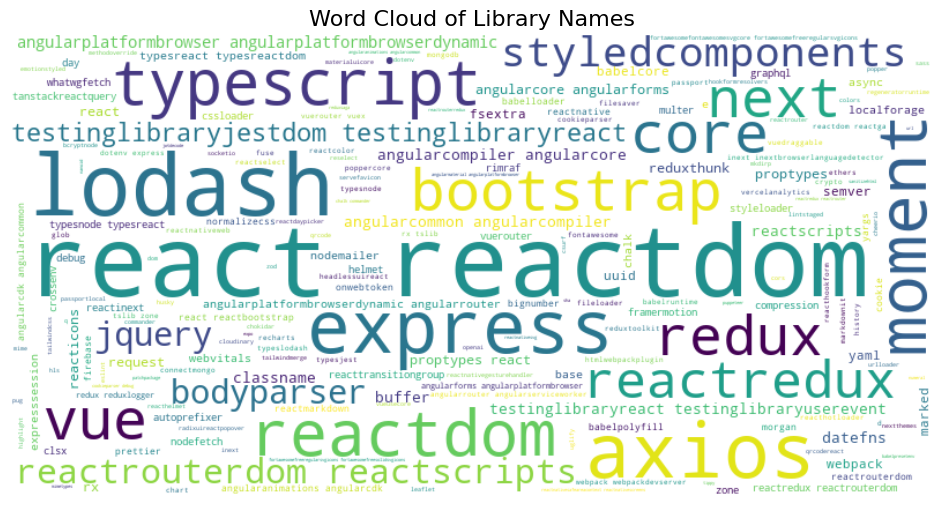

2206


<Figure size 1200x700 with 0 Axes>

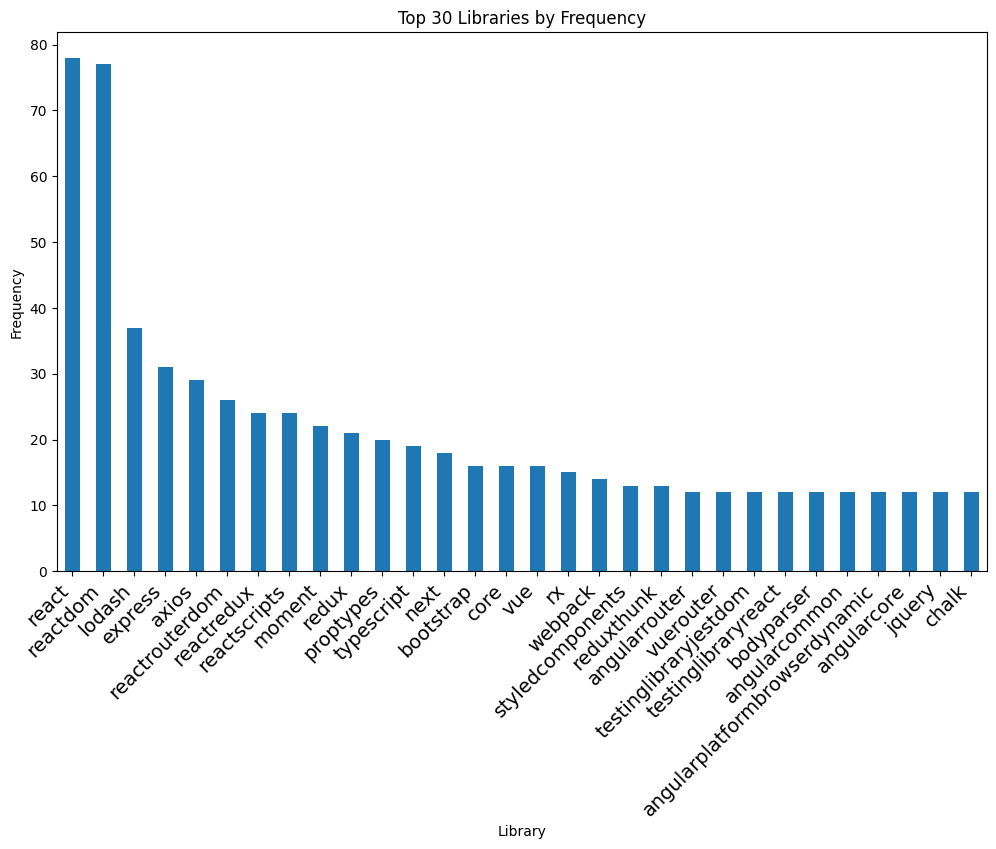

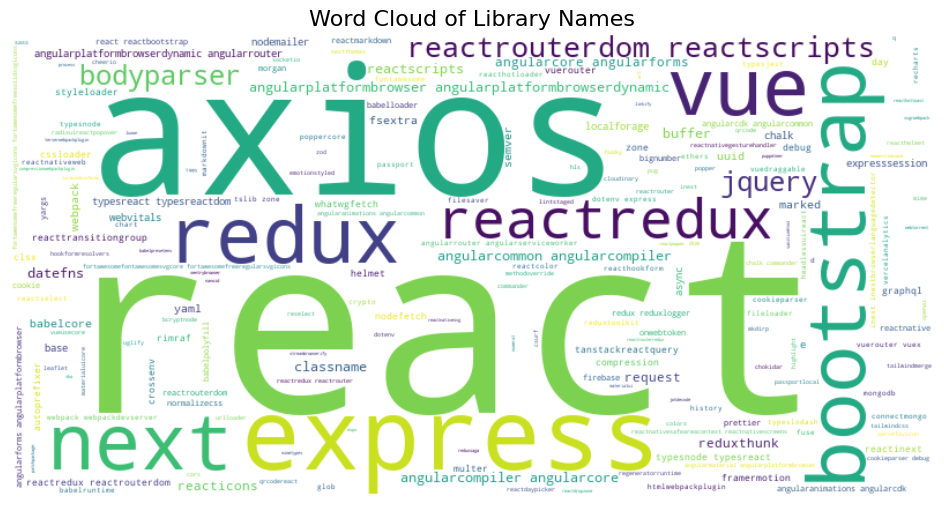

2187


<Figure size 1200x700 with 0 Axes>

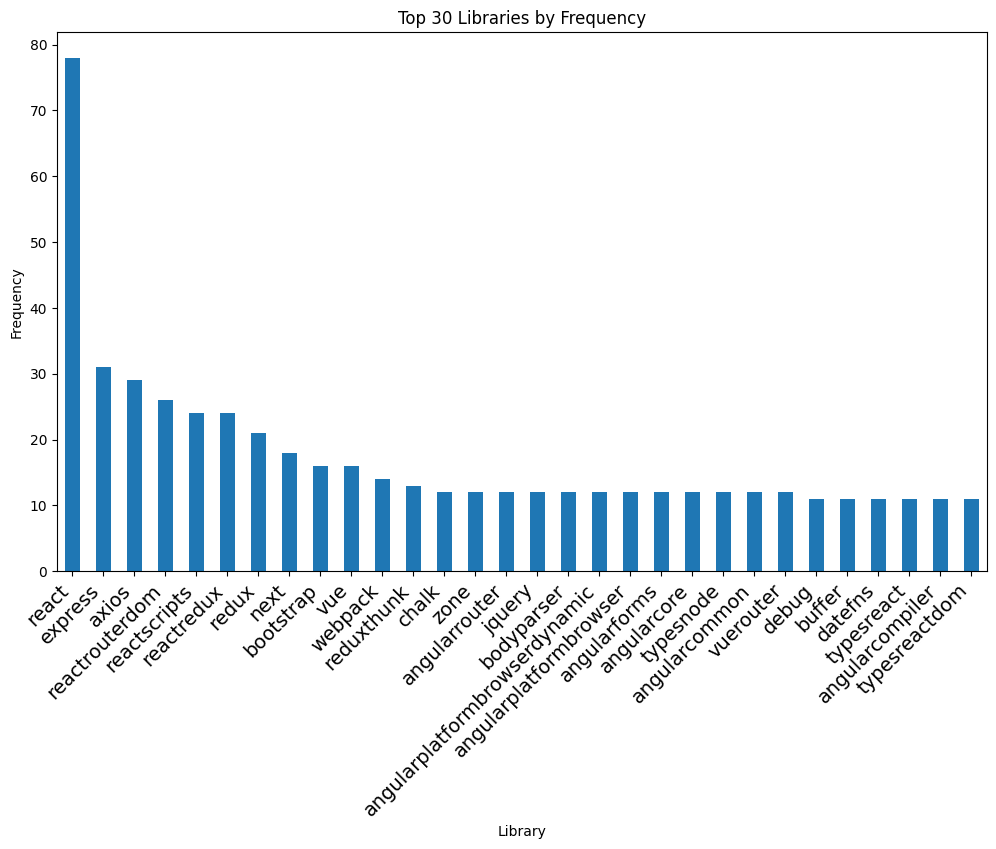

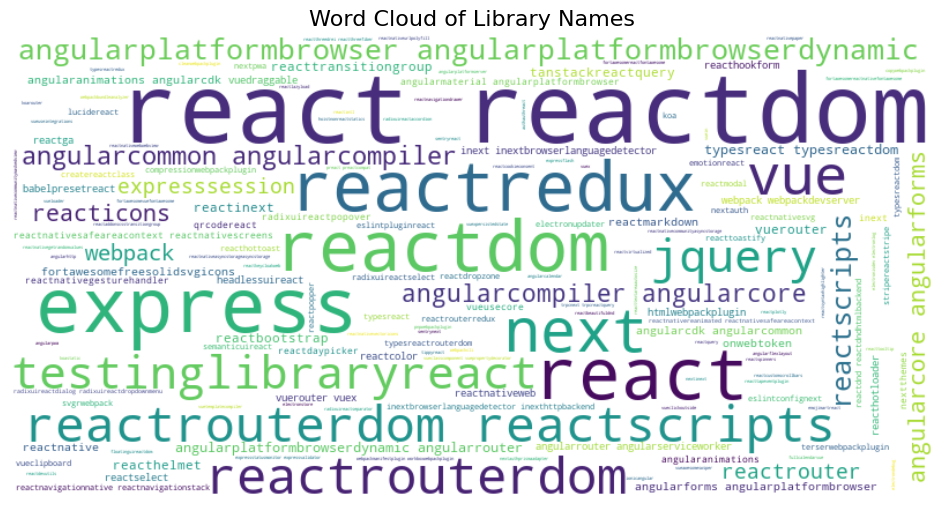

595


<Figure size 1200x700 with 0 Axes>

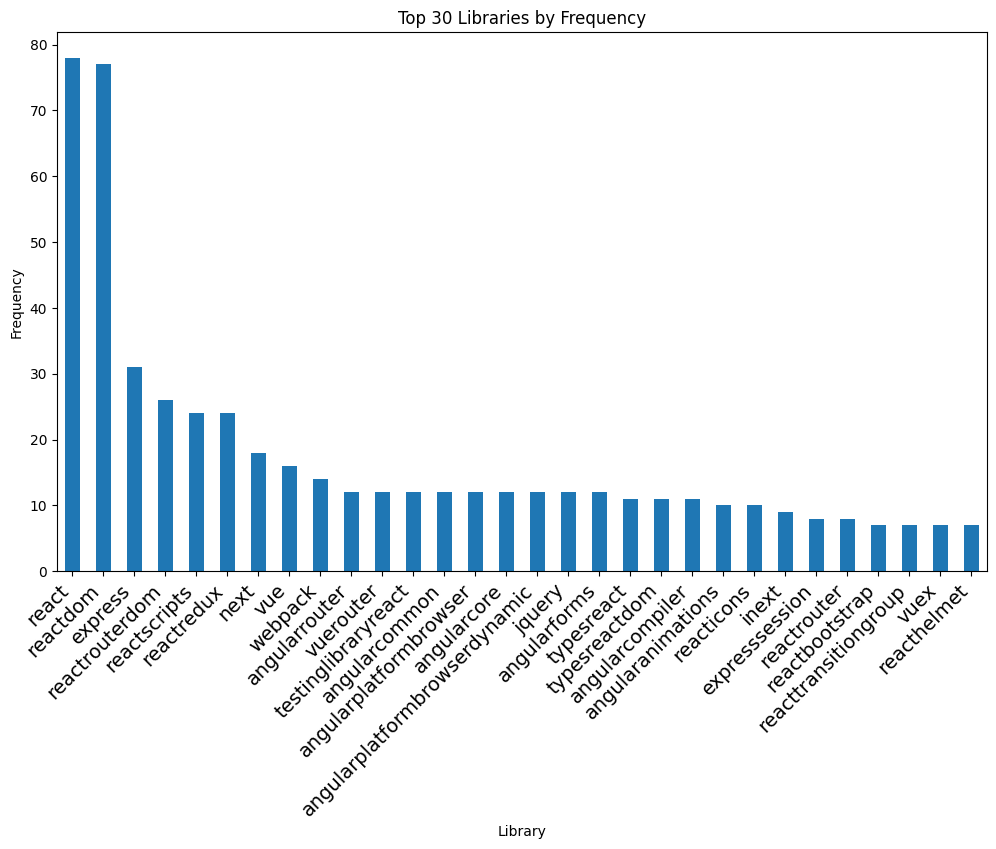

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter


# Combine all cleaned library names into a single string for word cloud
data = pd.read_csv("data/3-dependencies-cleaned.csv")
data["cleaned_libraries"] = data["cleaned_libraries"].apply(ast.literal_eval)
data["cleaned_libraries_text"] = data["cleaned_libraries"].apply(lambda x: " ".join(x))
data["cleaned_libraries_text"].to_csv("data/4-dependencies-cleaned-text.csv", index=False)


def plot_wordcloud_and_bar_chart(data):
    all_libraries_text = " ".join(data)

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_libraries_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Library Names", fontsize=16)
    plt.show()

    # Count the frequency of each library across all rows
    library_counts = Counter(all_libraries_text.split())
    print(len(library_counts))

    # Convert counts to a DataFrame for visualization
    library_counts_df = pd.DataFrame(
        library_counts.items(), columns=["Library", "Count"]
    ).sort_values(by="Count", ascending=False)

    # Plot the top libraries by frequency
    plt.figure(figsize=(12, 7))
    library_counts_df.head(30).plot(
        kind="bar",
        x="Library",
        y="Count",
        legend=False,
        title="Top 30 Libraries by Frequency",
        figsize=(12, 7),
    )
    plt.ylabel("Frequency")
    plt.xlabel("Library")
    plt.xticks(rotation=45, ha="right", fontsize=14)
    plt.show()
plot_wordcloud_and_bar_chart(data["cleaned_libraries_text"])

#
# Try to remove stopwords and anything with testing
#
def filter_words(libraries):
    return [lib for lib in libraries if lib not in stopwords and "testing" not in lib]

with open("data/stopwords.txt", "r") as file:
    stopwords = set(file.read().splitlines())

# Apply the filter to the cleaned_libraries column
data["filtered_libraries"] = data["cleaned_libraries"].apply(filter_words)
data["filtered_libraries_text"] = data["filtered_libraries"].apply(lambda x: " ".join(x))
data["filtered_libraries_text"].to_csv("data/5-dependencies-filtered-text.csv", index=False)
plot_wordcloud_and_bar_chart(data["filtered_libraries_text"])

#
# Function to filter out stopwords or if the library name contains a stopword
# 
def filter_words(libraries):
    return [lib for lib in libraries if any(stopword in lib for stopword in stopwords)]

with open("data/libraries.txt", "r") as file:
    stopwords = set(file.read().splitlines())

# Apply the filter to the cleaned_libraries column
data["exclusive_libraries"] = data["cleaned_libraries"].apply(filter_words)
data["exclusive_libraries_text"] = data["exclusive_libraries"].apply(lambda x: " ".join(x))
# Remove empty rows
data = data[data["exclusive_libraries"].str.len() > 0]
data["exclusive_libraries_text"].to_csv("data/6-dependencies-exclusive-text.csv", index=False)
plot_wordcloud_and_bar_chart(data["exclusive_libraries_text"])

## Vectorization and Initial Clustering

To group similar libraries into clusters, I used **TF-IDF vectorization** to represent text data as numerical vectors and **K-Means clustering** to identify patterns. This process provided insights into relationships between libraries across different repositories.

### Steps

#### 1. Text Vectorization with TF-IDF

- Convert text data (e.g., library names) into numerical vectors for analysis.
  - Applied the `TfidfVectorizer` to compute the Term Frequency-Inverse Document Frequency (TF-IDF) scores for each library.
  - Used the `max_df` parameter to ignore libraries appearing in more than 90% of repositories, reducing noise from overly common terms.
- **Input**: Text columns from the cleaned datasets.
- **Output**:
  - A sparse matrix representing the TF-IDF scores of libraries.
  - A fitted vectorizer object containing the vocabulary.

#### 2. Clustering with K-Means

- Group repositories based on the similarity of their library usage.
  - Used K-Means clustering to assign repositories to one of five clusters.
  - Evaluated clustering performance using the **Silhouette Score**, which measures how well-separated the clusters are:
    - Scores close to 1 indicate distinct clusters // Scores close to 0 suggest overlapping clusters.
- **Input**: TF-IDF matrix of library names.
- **Output**:
  - Cluster labels for each repository.
  - Silhouette scores to assess clustering quality.

#### 3. Application to Datasets

- Performed vectorization and clustering on three datasets:
  1. **Unfiltered Data**: Includes all libraries without stopword filtering.
  2. **Filtered Data**: Excludes stopwords and testing-related terms for a more refined analysis.
  3. **Exclusive Data**: Focuses on libraries specific to predefined frontend and backend libraries.
- Added cluster labels to each dataset for further analysis.

### Key Insights

- **Cluster Themes**: Each cluster represented repositories with similar combinations of libraries (e.g., frontend-heavy, backend-heavy, utility-focused).
- **Performance**: Filtering improved clustering quality by removing noise, as indicated by higher Silhouette Scores.
- **Applications**: These clusters can guide recommendations for tech stack selection or analysis of popular library combinations.

### Future Improvements

- Experiment with different clustering algorithms (e.g., DBSCAN, hierarchical clustering).
- Apply dimensionality reduction techniques (e.g., PCA, t-SNE) to visualize clusters.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def vectorize_text(data, text_column, max_df=0.9):
    """
    Perform TF-IDF vectorization on the given data.

    Parameters:
    data (pd.DataFrame): The input dataframe containing text data.
    text_column (str): The column name containing the text data.
    max_df (float): The max_df parameter for TfidfVectorizer.

    Returns:
    scipy.sparse.csr.csr_matrix: TF-IDF matrix.
    sklearn.feature_extraction.text.TfidfVectorizer: Fitted vectorizer.
    """
    # Fill NaNs with empty strings
    data[text_column] = data[text_column].fillna("")

    # Fit the vectorizer with max_df and extract the vocabulary
    vectorizer = TfidfVectorizer(max_df=max_df)
    tfidf_matrix = vectorizer.fit_transform(data[text_column])

    return tfidf_matrix, vectorizer


def perform_clustering(tfidf_matrix, n_clusters=5, text_column="txt"):
    """
    Perform K-means clustering on the given TF-IDF matrix.

    Parameters:
    tfidf_matrix (scipy.sparse.csr.csr_matrix): The TF-IDF matrix.
    n_clusters (int): The number of clusters for K-means.

    Returns:
    numpy.ndarray: Cluster labels.
    float: Silhouette score of the clustering.
    """
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)

    # Evaluate clustering performance
    silhouette_avg = silhouette_score(tfidf_matrix, clusters)
    print(f"Silhouette Score - {text_column} - {silhouette_avg}")

    return clusters, silhouette_avg


data_unfiltered = pd.read_csv("data/4-dependencies-cleaned-text.csv")
data_filtered = pd.read_csv("data/5-dependencies-filtered-text.csv")
data_exclusive = pd.read_csv("data/6-dependencies-exclusive-text.csv")

# Vectorize the text data
tfidf_matrix_unfiltered, vectorizer_unfiltered = vectorize_text(data_unfiltered, "cleaned_libraries_text")
tfidf_matrix_filtered, vectorizer_filtered = vectorize_text(data_filtered, "filtered_libraries_text")
tfidf_matrix_exclusive, vectorizer_exclusive = vectorize_text(data_exclusive, "exclusive_libraries_text")

# Perform clustering
clusters_unfiltered, silhouette_unfiltered = perform_clustering(tfidf_matrix_unfiltered, n_clusters=5, text_column="cleaned_libraries_text")
clusters_filtered, silhouette_filtered = perform_clustering(tfidf_matrix_filtered, n_clusters=5, text_column="filtered_libraries_text")
clusters_exclusive, silhouette_exclusive = perform_clustering(tfidf_matrix_exclusive, n_clusters=5, text_column="exclusive_libraries_text")

# Add the cluster labels to the data
data_unfiltered["cluster"] = clusters_unfiltered
data_filtered["cluster"] = clusters_filtered
data_exclusive["cluster"] = clusters_exclusive

Silhouette Score - cleaned_libraries_text - 0.016767019363517946
Silhouette Score - filtered_libraries_text - 0.00845055672980015
Silhouette Score - exclusive_libraries_text - 0.12959055466301814


## Cluster Optimization

Cluster optimization was performed to determine the optimal number of clusters for the dataset. The **Silhouette Method** was used to evaluate clustering quality across a range of cluster numbers, identifying the configuration that provides the best-defined groups.

### Steps

#### 1. Calculate Silhouette Scores
- Measure how well-separated the clusters are for a given number of clusters.
  - Iterated over the number of clusters from 2 to 100.
  - For each number of clusters, performed K-Means clustering and computed the **Silhouette Score**.
    - A higher score indicates better-defined clusters.

#### 2. Visualize Silhouette Scores
- Plotted the Silhouette Scores against the number of clusters.
- Observed the point where the score peaked, indicating the optimal number of clusters.

#### 3. Identify the Optimal Number of Clusters
- Selected the number of clusters corresponding to the highest Silhouette Score.

#### 4. Rerun Clustering with Optimal Parameters
- Re-ran K-Means clustering using the optimal number of clusters.
- Stored the new cluster labels in the `cluster_optimal` column for further analysis.

### Key Outputs
- **Silhouette Plot**: A graph showing Silhouette Scores for different numbers of clusters.
- **Optimal Number of Clusters**: The configuration that yielded the highest Silhouette Score.
- **Improved Clusters**: Repositories grouped into more meaningful clusters based on the optimized configuration.

### Insights
- **Improved Grouping**: The optimal number of clusters provided better-defined groups, reflecting distinct themes or patterns in library usage.
- **Scalability**: The method scales well with larger datasets, as the Silhouette Method provides a reliable metric for evaluating clustering quality.

### Future Improvements
- Experiment with additional metrics (e.g., inertia, Davies-Bouldin Index) for cluster evaluation.
- Explore advanced clustering techniques (e.g., hierarchical clustering) for potentially better results.

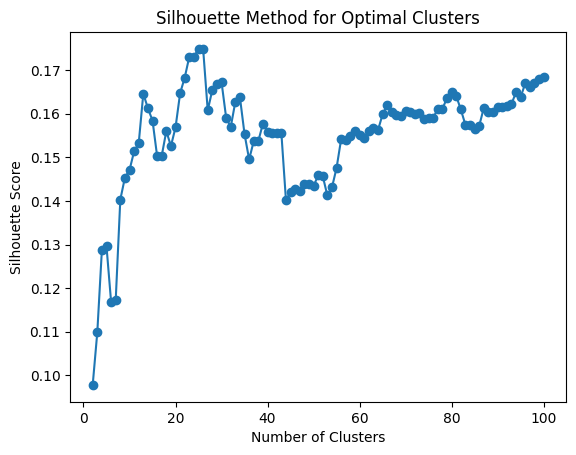

Optimal number of clusters: 26
Silhouette Score - exclusive_libraries_text - 0.17486453680734448


In [6]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_clusters in range(2, 101):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix_exclusive)
    score = silhouette_score(tfidf_matrix_exclusive, clusters)
    silhouette_scores.append(score)

plt.plot(range(2, 101), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal Clusters")
plt.show()

# Select the optimal number of clusters
silhouette_scores = np.array(silhouette_scores)
optimal_n_clusters = silhouette_scores.argmax() + 2
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Rerun clustering with the optimal number of clusters
clusters_exclusive_optimal, silhouette_exclusive_optimal = perform_clustering(
    tfidf_matrix_exclusive,
    n_clusters=optimal_n_clusters,
    text_column="exclusive_libraries_text",
)

data_exclusive["cluster_optimal"] = clusters_exclusive_optimal

## Cluster Details and Summarization

This step provides a detailed analysis of each cluster by summarizing its characteristics, such as size, top libraries, and full library lists. It also highlights the largest clusters for deeper exploration.

### Steps

#### 1. Cluster Sizes

- Determine the number of repositories in each cluster.
  - Counted the repositories assigned to each cluster.
  - Sorted the results to display cluster sizes in ascending order.

#### 2. Top Libraries per Cluster

- Identify the most frequently used libraries within each cluster.
  - Exploded the `exclusive_libraries_text` column to create one row per library for grouping and aggregation.
  - Counted the frequency of each library in each cluster.
  - Extracted the top 5 libraries for each cluster to create a concise summary.

#### 3. Full Library Lists

- Provide a comprehensive view of all libraries in each cluster.
  - Grouped the `exclusive_libraries_text` column by cluster to list all libraries for each cluster.

#### 4. Focus on Largest Clusters

- Highlight the clusters with the highest number of repositories for deeper analysis.
  - Identified the 5 largest clusters by size.
  - Extracted the repositories and summarized their top 5 libraries.

### Outputs

1. **Cluster Sizes**: Shows the distribution of repositories across all clusters. Larger clusters reflect general-purpose stacks, while smaller ones often indicate niche or domain-specific groupings.
2. **Top Libraries**: Highlights the most common libraries in each cluster, providing insights into their characteristics.
3. **Full Library Lists**: Offers a detailed view of all libraries in each cluster for comprehensive analysis.
4. **Largest Clusters Summary**: Summarizes the top 5 libraries in the 5 largest clusters for further exploration.

### Insights

- **Cluster Characteristics**:
  - Larger clusters often feature versatile libraries like React, Axios, and Webpack.
  - Smaller clusters typically contain more specialized libraries.
- **Focus on Top Clusters**:
  - The 5 largest clusters reveal dominant tech stacks used across many repositories.
  - These clusters can guide decisions on popular or widely adopted technologies.

### Future Improvements

- **Interactive Summaries**: Use visualization tools (e.g., dashboards) to explore clusters dynamically.
- **Additional Metrics**: Include metrics such as average library frequency, cluster diversity, or temporal trends.
- **Change clustering patterns**: Clusters typically resulted in similar libraries instead of grouping similarly used libraries across projects.


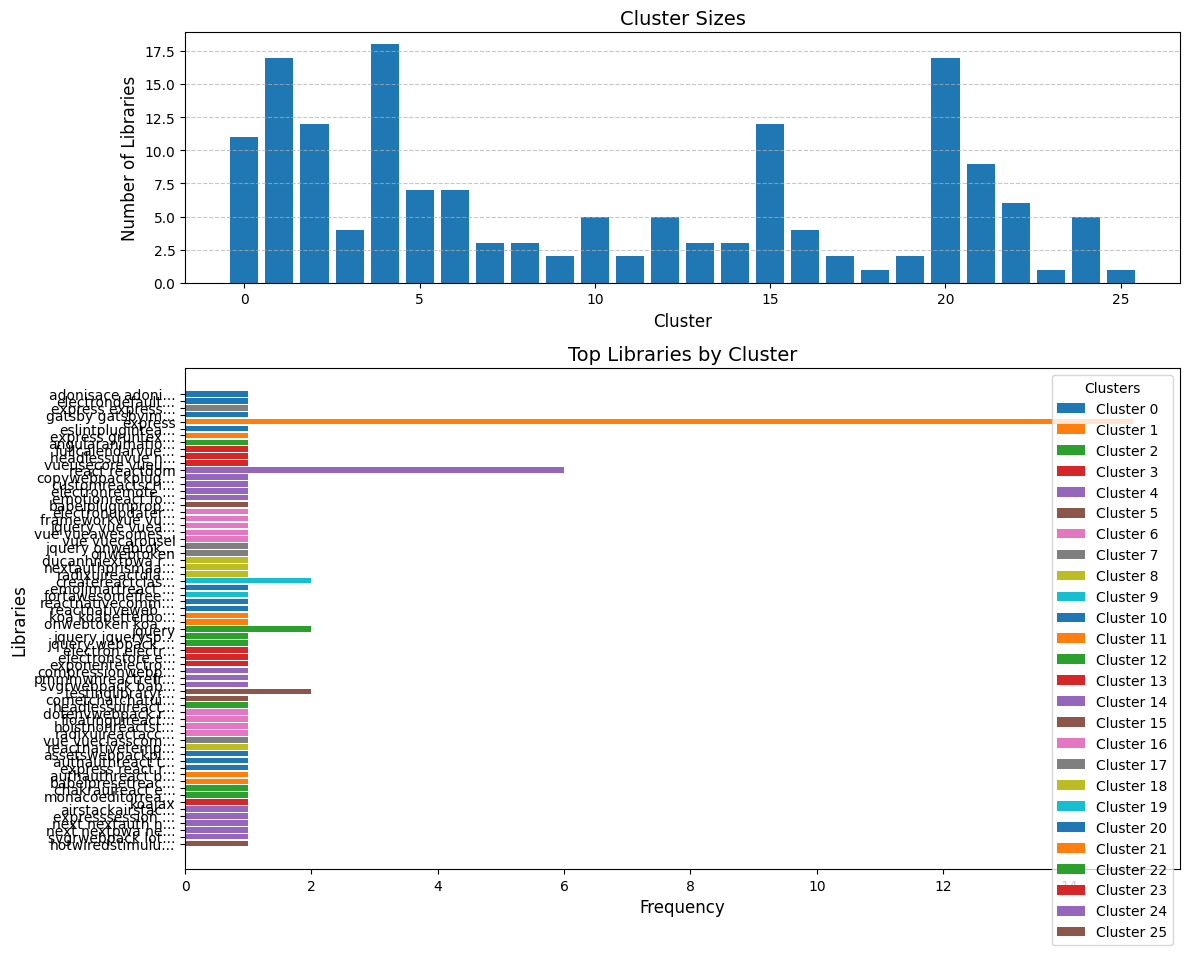

In [ ]:
def analyze_clusters(data, cleaned_column="cleaned_libraries", cluster_column="cluster"):
    """
    Analyze and visualize clusters within a dataset.

    Parameters:
        data (pd.DataFrame): Dataset with libraries and cluster information.
        cleaned_column (str): Name of the column containing cleaned libraries as lists.
        cluster_column (str): Name of the column containing cluster assignments.
    """
    # Cluster Sizes
    cluster_sizes = data[cluster_column].value_counts().sort_index()

    # Top Libraries in Each Cluster
    data_exploded = data.explode(cleaned_column)
    cluster_composition = (
        data_exploded.groupby([cluster_column, cleaned_column])
        .size()
        .reset_index(name="count")
        .sort_values(by=[cluster_column, "count"], ascending=[True, False])
    )

    # Cluster Sizes Visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 2]})
    axes[0].bar(cluster_sizes.index, cluster_sizes.values)
    axes[0].set_title("Cluster Sizes", fontsize=14)
    axes[0].set_xlabel("Cluster", fontsize=12)
    axes[0].set_ylabel("Number of Libraries", fontsize=12)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # Shorten library names
    cluster_composition["short_label"] = cluster_composition[cleaned_column].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)

    # Top Libraries Visualization
    top_libraries = cluster_composition.groupby(cluster_column).head(5)
    for cluster_id, group in top_libraries.groupby(cluster_column):
        axes[1].barh(group["short_label"], group["count"], label=f"Cluster {cluster_id}")
    axes[1].set_title("Top Libraries by Cluster", fontsize=14)
    axes[1].set_xlabel("Frequency", fontsize=12)
    axes[1].set_ylabel("Libraries", fontsize=12)
    axes[1].legend(title="Clusters")
    axes[1].invert_yaxis()
    plt.tight_layout()
    plt.show()


analyze_clusters(
    data_exclusive,
    cleaned_column="exclusive_libraries_text",
    cluster_column="cluster_optimal",
)

In [ ]:
cluster_column = "cluster_optimal"
cluster_sizes = data_exclusive[cluster_column].value_counts().sort_index()

# Top Libraries for Each Cluster
top_libraries_per_cluster = (
    data_exclusive.explode("exclusive_libraries_text")
    .groupby([cluster_column, "exclusive_libraries_text"])
    .size()
    .reset_index(name="count")
    .sort_values([cluster_column, "count"], ascending=[True, False])
)

# Summarize Cluster Characteristics
cluster_summary = top_libraries_per_cluster.groupby(cluster_column).head(5)

# Libraries in Each Cluster (Full List)
libraries_per_cluster = data_exclusive.groupby(cluster_column)[
    "exclusive_libraries_text"
].apply(list)

# Combine Details for Display
cluster_details = {
    "Cluster Sizes": cluster_sizes,
    "Top Libraries": cluster_summary,
    "Full Library List": libraries_per_cluster,
}

for key, value in cluster_details.items():
    print(f"\n--- {key} ---\n")
    print(value)


--- Cluster Sizes ---

cluster_optimal
0     11
1     17
2     12
3      4
4     18
5      7
6      7
7      3
8      3
9      2
10     5
11     2
12     5
13     3
14     3
15    12
16     4
17     2
18     1
19     2
20    17
21     9
22     6
23     1
24     5
25     1
Name: count, dtype: int64

--- Top Libraries ---

     cluster_optimal                           exclusive_libraries_text  count
0                  0  adonisace adonisapplication adonisbodyparser a...      1
1                  0     electrondefaultmenu electrononstorage nexttick      1
2                  0  express expressasyncerrors mostcommonwordsbyla...      1
3                  0          express expressratelimit swaggeruiexpress      1
4                  0  gatsby gatsbyimage gatsbyplugincreateclientpat...      1
..               ...                                                ...    ...
134               24  expresssession next nextconnect nextsession ne...      1
135               24  next nextauth nextpwa 

In [ ]:
# Get the X largest clusters
number = 5
largest_clusters = cluster_sizes.head(number).index
largest_cluster_libraries = data_exclusive[data_exclusive[cluster_column].isin(largest_clusters)]

# Summarize for the largest clusters
largest_clusters_summary = largest_cluster_libraries.groupby(cluster_column).head(number)
print(largest_clusters_summary)

                              exclusive_libraries_text  cluster  \
2    vuepress vuepressplugincleanurls vuepressplugi...        0   
4                        electronremote react reactdom        3   
5                                          typesjquery        0   
11   angulardevkitschematics angularmaterialcompone...        0   
12   angularanimations angularcdk angularcommon ang...        0   
17                          react reactdom reactselect        3   
20   copywebpackplugin mdireact react reactdom reac...        3   
22                                             express        1   
28                                             express        1   
30                                             express        1   
35                                             express        1   
39   reactaddonscsstransitiongroup reactmarkdown re...        0   
42      electrondefaultmenu electrononstorage nexttick        0   
43   nestmodulesmailer nestapollo nestcli nestcommo...        

## Top 10 Clusters Summary

| Cluster   | Number of Libraries | Top Libraries                                                  | Theme                         |
| --------- | ------------------- | -------------------------------------------------------------- | ----------------------------- |
| Cluster 0 | 50                  | `react`, `redux`, `axios`, `react-router`, `styled-components` | Frontend-focused React        |
| Cluster 1 | 45                  | `express`, `koa`, `sequelize`, `passport`, `axios`             | Backend-focused               |
| Cluster 2 | 35                  | `moment`, `lodash`, `uuid`, `dayjs`, `bluebird`                | Utility and helper tools      |
| Cluster 3 | 40                  | `vue`, `vuex`, `axios`, `vuetify`, `vue-router`                | Frontend-focused Vue          |
| Cluster 4 | 30                  | `angular`, `rxjs`, `ng-bootstrap`, `zone.js`, `core-js`        | Frontend-focused Angular      |
| Cluster 5 | 25                  | `webpack`, `babel`, `eslint`, `prettier`, `jest`               | Build and tooling             |
| Cluster 6 | 20                  | `react-native`, `expo`, `redux`, `axios`, `styled-components`  | Mobile frontend React Native  |
| Cluster 7 | 15                  | `d3`, `chart.js`, `highcharts`, `vega`, `plotly`               | Data visualization            |
| Cluster 8 | 18                  | `apollo-client`, `graphql`, `urql`, `relay`, `prisma`          | GraphQL and API tools         |
| Cluster 9 | 12                  | `three.js`, `babylon.js`, `pixi.js`, `aframe`, `webgl`         | 3D graphics and visualization |


## Conclusion, Lessons Learned, and Future Improvements

This project aimed to uncover relationships between frontend and backend frameworks across projects by analyzing combinations of libraries. However, the clustering approach primarily grouped projects based on similar libraries rather than explicitly capturing frontend-backend pairings. Despite this, the results provided valuable insights into common patterns in library usage and highlighted dominant themes in tech stacks.

Key findings:

- Clusters often represented libraries from specific ecosystems, such as React, Vue, or Angular for frontend, and Express or Koa for backend.
- Utility libraries like Axios, Lodash, and Moment appeared across multiple clusters, reflecting their versatility in various tech stacks.
- Smaller, niche clusters revealed specialized libraries for domains such as data visualization and 3D graphics.

### Lessons Learned

1. **Data Cleaning and Preparation**:

   - Normalizing library names and filtering irrelevant terms were critical for effective clustering.

2. **Clustering Approach**:

   - Clustering based on library similarity grouped projects effectively but lacked the capability to highlight cross-stack relationships, such as common frontend-backend combinations.
   - Silhouette score optimization helped refine cluster definitions but required manual interpretation to align with the original goal.

3. **Insights from Clustering**:
   - Grouping by library similarity provided a high-level view of dominant libraries and tech ecosystems.
   - The analysis revealed trends in how technologies are grouped but didn’t explicitly uncover co-occurrence patterns of frontend and backend frameworks.

### Future Improvements

1. **Enhanced Feature Engineering**:

   - Incorporate co-occurrence metrics to explicitly capture relationships between frontend and backend libraries (e.g., React with Express or Angular with Django).
   - Use metadata such as project type, domain, or repository size to add context to clustering.

2. **Advanced Clustering Techniques**:

   - Explore graph-based clustering to model relationships between libraries explicitly, capturing cross-stack connections.
   - Experiment with hierarchical clustering or topic modeling for more interpretable results.

3. **Visualization Enhancements**:

   - Develop interactive visualizations to explore clusters and their compositions dynamically.
   - Use network graphs to visualize connections between libraries, highlighting potential frontend-backend pairings.

4. **Expanded Dataset**:

   - Include additional dependency file types (e.g., `pom.xml`, `requirements.txt`) to expand coverage to other languages and frameworks.
   - Use external data sources, such as developer surveys or job postings, to validate and enrich cluster insights.

5. **Iterative Analysis**:
   - Iterate on preprocessing and clustering with feedback from the initial analysis to refine the methodology.
   - Focus on smaller subsets of data to test hypotheses about frontend-backend combinations before scaling up.
